In [4]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [5]:
pwd

'/home/faizan/cvit/summer_1/pytorch'

In [6]:
plt.ion()

In [94]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [95]:
data_dir = 'data/hymenoptera_data'

In [96]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [102]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 244
    Root location: data/hymenoptera_data/train

In [103]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)for x in ['train', 'val']}

In [105]:
dataloaders['train']

In [106]:
len(dataloaders['val'])

39

In [36]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [37]:
dataset_sizes

{'train': 244, 'val': 153}

In [38]:
class_names = image_datasets['train'].classes

In [39]:
class_names

['ants', 'bees']

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
device

device(type='cpu')

In [76]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [77]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

In [78]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [93]:
out[2].shape

torch.Size([228, 906])

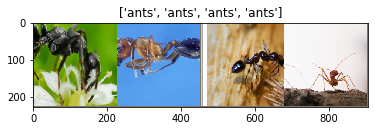

In [80]:
imshow(out, title=[class_names[x] for x in classes])

In [107]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                print(loss.item())
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [108]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [109]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
0.8720716238021851
0.5889615416526794
0.576435387134552
0.40898603200912476
0.44410350918769836
1.680825114250183
0.1464044451713562
0.7218867540359497
1.103090763092041
1.483795404434204
1.0430353879928589
0.546038806438446
0.3538565933704376
1.452805995941162
2.4117352962493896
0.6156156659126282
0.5764277577400208
0.23434558510780334
0.39862486720085144
0.2929641604423523
1.4153369665145874
0.6455005407333374
0.9622801542282104
0.49606144428253174
0.349100798368454
0.4112987518310547
0.597932755947113
0.26141637563705444
0.3698987066745758
0.39163461327552795
0.2065291553735733
0.989780068397522
0.2538645565509796
0.8746610879898071
0.8937482833862305
0.3299899101257324
0.15675866603851318
0.14428487420082092
0.2669881582260132
1.3422510623931885
1.3271872997283936
0.4740124046802521
0.28601905703544617
1.4934990406036377
0.04333287477493286
0.8408173322677612
0.08281123638153076
0.11946573108434677
0.6191287040710449
0.0541154146194458
0.1434946358203888
0.137

0.07982057332992554
0.024140655994415283
0.6359939575195312
0.22507686913013458
0.25649958848953247
1.001476764678955
0.37663689255714417
0.20586661994457245
0.2034580409526825
0.24184705317020416
0.20096321403980255
0.11548886448144913
1.0632543563842773
0.2631928324699402
0.04900422692298889
0.03690904378890991
0.2711273431777954
1.0922117233276367
0.43241894245147705
0.9757267236709595
0.05328993499279022
0.028679698705673218
0.7737734317779541
0.8465358018875122
1.946002721786499
0.147544264793396
0.3576771020889282
0.20855391025543213
0.19051560759544373
0.4557569622993469
0.0645979642868042
1.460251808166504
0.07774246484041214
0.8538970351219177
0.0513702929019928
0.8922580480575562
0.07119141519069672
0.02508041262626648
0.02425384521484375
0.1855776011943817
0.374724417924881
0.025114595890045166
0.20680207014083862
0.49288737773895264
0.10561756044626236
0.05476027727127075
0.10701616108417511
0.026384055614471436
0.23117589950561523
0.024937808513641357
0.09163494408130646
0

0.08190116286277771
0.034488484263420105
0.05758301168680191
0.09347373247146606
0.9299556016921997
0.04156474769115448
0.11190585792064667
0.08307452499866486
0.02688746154308319
0.2320464551448822
1.4098504781723022
0.5440521240234375
0.017407715320587158
0.4235779345035553
0.43295833468437195
0.27406972646713257
0.4363010823726654
0.004283338785171509
0.22106552124023438
0.13210493326187134
0.035085082054138184
0.5204177498817444
0.022849321365356445
0.0658927708864212
0.2743988633155823
0.006214052438735962
0.007848620414733887
0.20403775572776794
0.038243308663368225
0.09355753660202026
0.06450004875659943
0.07924620807170868
0.08476842939853668
0.0036124587059020996
1.3039578199386597
0.027213528752326965
0.10866834968328476
0.2672588527202606
0.018968015909194946
0.1994660198688507
0.026915892958641052
0.09193941950798035
0.4649481475353241
0.5617964863777161
0.022076040506362915
1.3486363887786865
0.08771200478076935
0.10984817147254944
0.2035243809223175
0.0501432865858078
0.1

0.07167010009288788
0.13735729455947876
0.10258162021636963
val Loss: 0.2305 Acc: 0.9020

Epoch 12/24
----------
0.11624018102884293
0.03299713134765625
0.09253960847854614
0.28782594203948975
0.13281545042991638
0.13162368535995483
0.35486024618148804
0.229478657245636
0.4748280346393585
0.009380817413330078
0.1482900083065033
0.13001284003257751
0.025793135166168213
0.1429099440574646
0.7839192748069763
0.40028268098831177
0.11303214728832245
0.008073955774307251
0.009101003408432007
0.2782169580459595
0.35770225524902344
1.331397294998169
0.22078627347946167
0.1358465701341629
0.020911484956741333
0.8172110915184021
0.20411080121994019
1.2219750881195068
0.024046272039413452
0.40650612115859985
0.01813468337059021
0.10359711199998856
0.06395530700683594
0.053205594420433044
1.1730291843414307
0.8621290326118469
0.30523747205734253
0.026122063398361206
0.17686209082603455
0.13129034638404846
0.01611003279685974
0.16293326020240784
0.022148340940475464
0.037413954734802246
0.112802512

0.03327040374279022
0.050067394971847534
0.9200558662414551
0.12044091522693634
0.6482669711112976
1.119659185409546
0.049723997712135315
0.0006093978881835938
val Loss: 0.2134 Acc: 0.9216

Epoch 16/24
----------
0.005261480808258057
0.08883921802043915
0.08417347073554993
0.7615108489990234
0.12896808981895447
0.2917974889278412
0.7271093130111694
0.17457301914691925
0.07830879837274551
0.298535019159317
0.09815645962953568
0.09315942227840424
0.824537456035614
0.859210193157196
0.03199145197868347
0.027377277612686157
1.1428874731063843
0.04122741520404816
0.13632377982139587
0.5142507553100586
0.02841566503047943
0.07519176602363586
0.08781851083040237
0.08122310042381287
0.06288857012987137
0.0058408379554748535
0.5399690866470337
0.04061982035636902
0.1564135104417801
0.27778181433677673
0.056062400341033936
0.07596121728420258
0.064989373087883
0.03070211410522461
0.08302043378353119
0.8681330680847168
0.8210749626159668
0.012180507183074951
1.0825445652008057
0.0963868498802185


0.007580071687698364
0.00928547978401184
0.009271234273910522
0.01231163740158081
0.18734748661518097
0.007047414779663086
0.005613505840301514
0.07141683250665665
0.006779849529266357
1.1513371467590332
0.13638778030872345
0.17072267830371857
val Loss: 0.2041 Acc: 0.9412

Epoch 20/24
----------
0.8373472690582275
0.02119693160057068
0.049713149666786194
0.2609165906906128
0.011234253644943237
1.307279348373413
1.0371981859207153
1.5344563722610474
0.00997835397720337
0.13369819521903992
0.017171218991279602
1.0988589525222778
0.09457884728908539
0.9476668834686279
0.10470685362815857
0.9399387836456299
0.09102988988161087
0.20127753913402557
0.23862572014331818
0.014970958232879639
0.43018919229507446
0.09114798158407211
0.009925812482833862
0.07090930640697479
0.2970724105834961
0.018719881772994995
0.4411531984806061
0.14976000785827637
0.20759271085262299
0.008837968111038208
0.1843944489955902
1.0771373510360718
0.10645933449268341
0.14421682059764862
1.0004656314849854
0.18358263

0.020610690116882324
0.6855573654174805
1.3002417087554932
0.45385968685150146
0.0024585723876953125
1.5535366535186768
0.038094520568847656
0.18865454196929932
0.004797250032424927
0.015070736408233643
0.8416458964347839
0.005560040473937988
0.06992873549461365
0.05358826369047165
0.014895141124725342
0.2737135887145996
0.39485326409339905
0.6183782815933228
val Loss: 0.2093 Acc: 0.9216

Epoch 24/24
----------
0.23553884029388428
0.1266006976366043
0.7190033197402954
0.011705547571182251
0.12320197373628616
0.17099794745445251
0.26484501361846924
0.013675153255462646
0.18194624781608582
0.45281875133514404
0.007704317569732666
0.04957932233810425
0.05825468897819519
0.006728112697601318
0.048331648111343384
0.9753319025039673
0.8608173131942749
0.37230247259140015
0.9131676554679871
0.013449996709823608
0.020918548107147217
0.07166074216365814
0.5383145809173584
0.4006606936454773
0.10813335329294205
0.14730671048164368
0.003691166639328003
0.034196943044662476
0.12742528319358826
0.9